# Задание 2

Седых Иван Дмитриевич БПМ181

In [339]:
import math

import numpy as np
import sympy as sym
from scipy import odr
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns


plt.style.use('ggplot')

---
## Task 3

[Threften Bau book](https://mseas.mit.edu/group/References/Books/Trefethen_Bau%20-%20Numerical%20Linear%20Algebra.pdf)

In [479]:
def plot_svd_vectors(A):
    U, s, V = np.linalg.svd(A, full_matrices=False)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))
    ax1.axis('equal')
    ax2.axis('equal')

    # plot circle
    x = np.linspace(-1, 1, 1000)
    y = np.sqrt(1 - x ** 2)
    color1 = '#1190FF'
    ax1.plot(x, y, c=color1)
    ax1.plot(x, -y, c=color1)
    # draw right singular vectors
    origin = np.zeros_like(V.T)
    ax1.quiver(*origin, V[0], V[1], scale_units='xy', scale=1, color=color1)
    ax1.text(*0.5 * V[:, 0], r"$\vec{v_1}$", color=color1, size=15)
    ax1.text(*0.5 * V[:, 1], r"$\vec{v_2}$", color=color1, size=15)

    # make transformation and plot ellipse
    color2 = '#FF9A13'
    x, y = A[:2] @ np.array([x, y])
    ax2.plot(x, y, color=color2)
    ax2.plot(-x, -y, color=color2)
    # plot left singluar vectors
    US = U * s # multiply by singuar values to stretch
    origin = np.zeros((2,2))
    ax2.quiver(*origin, US[0], US[1], scale_units='xy', scale=1, color=color2)
    ax2.text(*0.5 * US[:2, 0], r"$\vec{\sigma_1 u_1}$", color=color2, size=15)
    ax2.text(*0.5 * US[:2, 1], r"$\vec{\sigma_2 u_2}$", color=color2, size=15)

    fig.show()

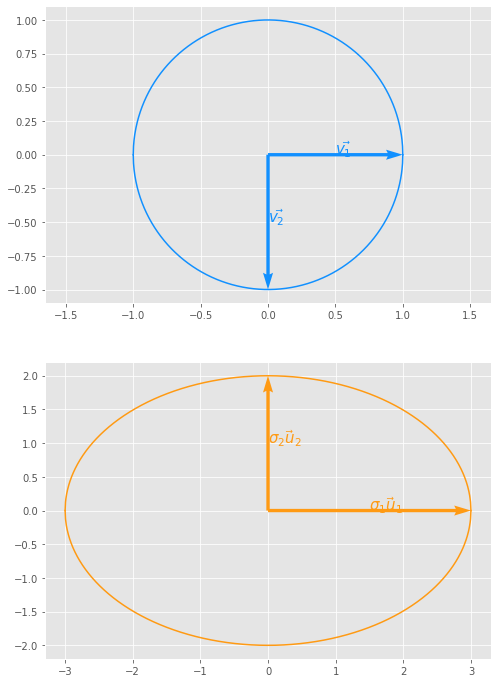

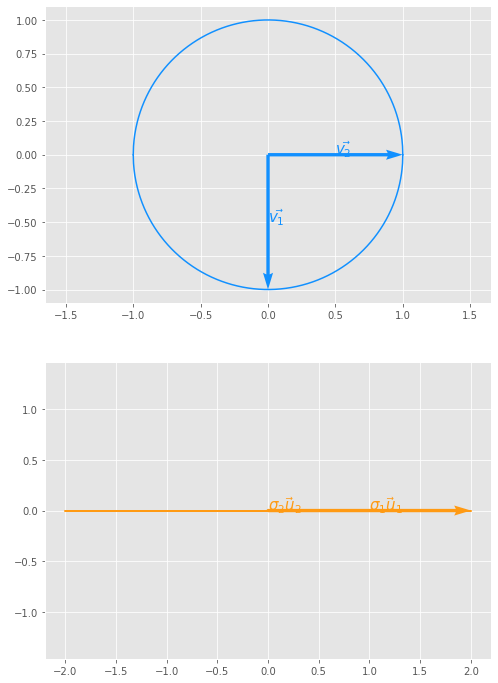

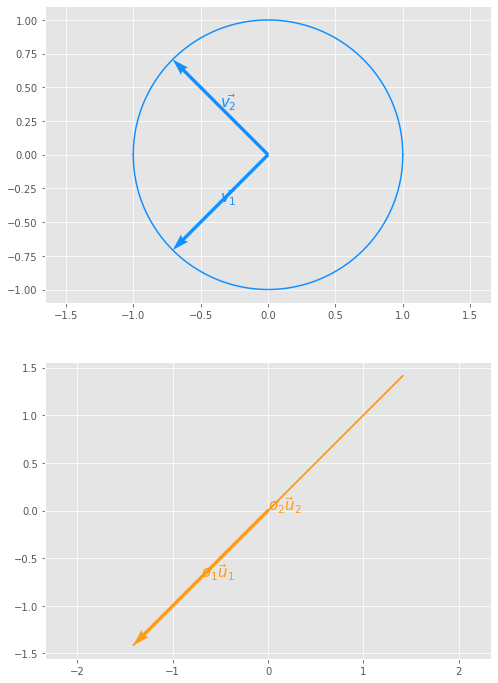

In [481]:
A1 = np.array([
    [3, 0],
    [0, -2],
])
A2 = np.array([
    [0, 2],
    [0, 0],
    [0, 0],
])
A3 = np.array([
    [1, 1],
    [1, 1],
])
for A in [A1, A2, A3]:
    plot_svd_vectors(A)

---
## Task 5

In [ ]:
def woodbury(a, U, V):
    """ (A + UV)^(-1)
    assuming A is diagonal matrix
    A -- n*n
    U -- n*k
    C -- k*k (C=np.eye in this case)
    V -- k*n
    """
    n = A.shape[0]
    k = U.shape[1]
    # storing only diagonal elements (A is diagonal)
    A_inv_diag = 1. / np.diag(A)
    # B is (k*k) matrix so its faster to invert
    B_inv = np.linalg.inv((np.eye(k) + (V * A_inv_diag) @ U))
    res = np.diag(A_inv_diag) - (A_inv_diag.reshape(-1, 1) * U @ B_inv @ V * A_inv_diag)
    return res

In [ ]:
# проверили что работает
n_tests = 200
fail_cnt = 0
for test in tqdm.tqdm(range(n_tests)):
    p = np.random.randint(500, 1000)
    k = np.random.randint(10, 250)

    A = np.diag(np.random.randn(p))
    U = np.random.randn(p, k)
    V = np.random.randn(k, p)

    M = A + U @ V
    M_inv_true = np.linalg.inv(M)
    M_inv = woodbury(A, U, V)
    if not np.allclose(M_inv, M_inv_true):
        fail_cnt += 1

print('\n')
print(f"{fail_cnt} fails in {n_tests} tests")

In [ ]:
%%timeit

p = 5000
k = 100
A = np.diag(np.random.randn(p))
U = np.random.randn(p, k)
V = np.random.randn(k, p)

M = A + U @ V
M_inv_true = np.linalg.inv(M)

In [ ]:
%%timeit

p = 5000
k = 100
A = np.diag(np.random.randn(p))
U = np.random.randn(p, k)
V = np.random.randn(k, p)

M_inv = woodbury(A, U, V)

**Видим, что мы ускорили работу в 10 раз.**  
Произошло это потому, что обращение матрицы обычно делается за $O(n^3)$, а мы обращали только матрицу размера $k$, который сильно меньше $n$, тем самым получили асимптотику $O(k^3)$.  
Еще я исползовал тот факт, что матрица $A$ - диагональная, что позволяет делать умножения и обращать ее быстрее чем в общем случае.

---
## Task 6 (ODR)

Мне сразу бросилось в глаза сходство с методом PCA. Потому что по сути нам нужно найти вектор нормали плоскости вдоль которого дисперсия наименьшая. Эта плоскость и будет лучшим приближением датасета в терминах ортогональных расстояний.

In [168]:
with np.load('data_distance_svd.npz') as data :
    xp, yp, zp = data['xp'], data['yp'], data['zp']
    X = np.array([xp, yp, zp]).T

Введем функционал качества, который будем минимизировать.  
$$
d_i = (x_i - c)^T \vec{n} \\
F(c, \vec{n}) = \sum_{i=1}^l d_i^2 \longrightarrow \min_{||n||=1} \\
$$
Мы хотим, чтобы вектор нормали был единичной длины.  
Дальше, помучившись с дифференцированием и решением $\frac {\partial F} {\partial c} = 0$, выясним, что минимум достигается в $c = \frac 1 l \sum_{i=1} x_i = \bar{x}$ -- то есть в среднем нашей выборки(это дается в качестве упражнения в книге [\[3\]]).

In [331]:
c = X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
normal = V[2] # normal vector to surface

# make projections
# 1st way:
q = 2 # rank of approximation
V_q = V[:q]
H_q = V_q.T @ V_q # projector matrix
projs = X @ H_q

# 2nd way:
# s_trunc = s.copy()
# s_trunc[q:] = 0
# projs = U @ np.diag(s_trunc) @ V + c

# make surface
xx, yy = np.meshgrid(np.arange(np.min(X[:, 0]), np.max(X[:, 0])), np.arange(np.min(X[:, 1]), np.max(X[:, 1])))
d = -c @ normal
z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

# plotting
fig = go.Figure(data=[
    go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', name='original'),
    go.Surface(x=xx, y=yy, z=z,
        name='approximation',
        showlegend=True,
        showscale=False, 
        opacity=0.7, 
        colorscale=[[0, 'rgb(0,255,0)'], [1, 'rgb(0,255,0)']],
    ),
    go.Scatter3d(x=projs[:, 0], y=projs[:, 1], z=projs[:, 2],
        name='projections',
        mode='markers', 
        marker=dict(
            size=5,
            color='red',
            opacity=0.8,
            symbol='cross'
        )
    ),
])
fig.update_layout(
    width=600,
    height=500,
    margin=dict(l=0, r=0, b=0, t=20),
)
fig.show()

### scipy

Сверим мое решение с тем, что реализовано в scipy

сформулируем задачу как регрессию $z$ по переменным $x,y$  
$z \approx \beta_0 x + \beta_1 y + \beta_2$.  
в результате получим параметры $\beta_i$ такие, что ортогональное расстояние наименьшее. 

In [232]:
import scipy.odr.odrpack as odrpack

x = np.row_stack((X[:, 0], X[:, 1]))
z = X[:, 2]

def f(B, x):
    return B[0] * x[0] + B[1] * x[1] + B[2]
linear = odrpack.Model(f)
mydata = odrpack.RealData(x, z)

myodr = odrpack.ODR(mydata, linear, beta0=[1., 1.,1.])
myoutput = myodr.run()
myoutput.pprint()

betas = myoutput.beta
print("Scipy betas:")
print(betas)
print("my betas:")
print("{:.8} {:.8} {:.8}".format(-normal[0] / normal[2], -normal[1] / normal[2], -d / normal[2]))

Beta: [ 0.85983352  0.19201913 -0.19144687]
Beta Std Error: [0.06009224 0.05548452 0.44380248]
Beta Covariance: [[ 5.14840491e-03 -2.10872049e-04 -2.58183546e-02]
 [-2.10872049e-04  4.38914149e-03 -2.14663209e-02]
 [-2.58183546e-02 -2.14663209e-02  2.80811835e-01]]
Residual Variance: 0.7013972098089103
Inverse Condition #: 0.045794474969635804
Reason(s) for Halting:
  Sum of squares convergence
Scipy betas:
[ 0.85983352  0.19201913 -0.19144687]
my betas:
0.85983416 0.19201806 -0.19144418


References:

1. [http://oc.cs.msu.ru/smirnov/PPP/Maple_Matlab_(Gander_Hrebicek).pdf] (кстати прикольная книжка) страница 84
2. [https://www.ltu.se/cms_fs/1.51590!/svd-fitting.pdf]
3. Hastie, Tibshirani -- глава 14
3. [https://www2.math.ethz.ch/education/bachelor/lectures/hs2014/other/linalg_INFK/svdneu.pdf]
4. [http://www.ime.unicamp.br/~marianar/MI602/material%20extra/svd-regression-analysis.pdf]
5. [готовое решение ODR scipy](https://docs.scipy.org/doc/scipy/reference/odr.html)

---
## Task 7 (Прокрустово преобразование)

[http://oc.cs.msu.ru/smirnov/PPP/Maple_Matlab_(Gander_Hrebicek).pdf]

### (a)

In [485]:
data = np.loadtxt('signatureData2.csv', delimiter=',')
X1 = data[:, :2]
X2 = data[:, 2:]

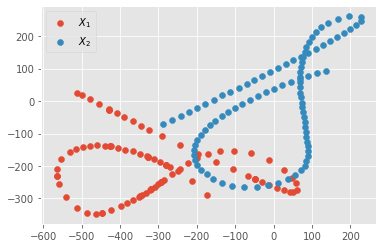

In [501]:
plt.scatter(*X1.T, label='$X_1$')
plt.scatter(*X2.T, label='$X_2$')
plt.legend()
plt.show()

In [496]:
x1 = X1.mean(axis=0)
x2 = X2.mean(axis=0)
X1_centered = X1 - x1
X2_centered = X2 - x2

U, d, V = np.linalg.svd(X1_centered.T @ X2_centered)
R = U @ V

mu = x2 - R.T @ x1
X1_fixed = X1 @ R + mu

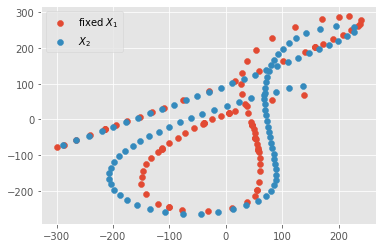

In [499]:
plt.scatter(*X1_fixed.T, label='fixed $X_1$')
plt.scatter(*X2.T, label='$X_2$')
plt.legend()
plt.show()